In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization

## Load nuScenes SDK and data

In [2]:
nuScenes_data_path = './v1.0-mini'
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='singapore-queenstown')

In [3]:
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

# Map Encoding Demo

In [4]:
with open('../processed/nuScenes_test_mini_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [5]:
ph = 6
log_dir = './models'

In [6]:
scene = eval_scenes[1]
scene.name

'916'

In [7]:
print(len(scene.nodes))
print(scene.nodes[1])
print(scene.nodes[1].data.header)
print(scene.nodes[1].data[:, ('position', 'x')])
print(len(scene.nodes[1].data[:, ('position', 'x')]))
print(len(scene.nodes[1].data[:, ('velocity', 'x')]))
print(len(scene.nodes[1].data[:, ('acceleration', 'x')]))

27
VEHICLE/ego
[('position', 'x'), ('position', 'y'), ('velocity', 'x'), ('velocity', 'y'), ('acceleration', 'x'), ('acceleration', 'y'), ('heading', 'x'), ('heading', 'y'), ('heading', '°'), ('heading', 'd°'), ('velocity', 'norm'), ('acceleration', 'norm')]
[113.64779694 114.03232778 114.06803346 113.83861967 113.26101991
 112.37949359 111.26596208 109.96466616 108.53810517 107.06644414
 105.55590116 103.98504532 102.35460221 100.67314667  98.88767171
  97.01705309  95.11139874  93.17280814  91.185167    89.26017135
  87.46334555  85.67354175  83.81601856  81.93135368  79.9730589
  77.92924048  75.85629535  73.78938249  71.61546401  69.4655132
  67.34519051  65.23372501  63.20397713  61.26416822  59.42708654
  57.58872688  55.81587041  53.98216183  52.11507964  50.30037001]
40
40
40


In [8]:
# Define ROI in nuScenes Map
# x_min = 773.0
# x_max = 1100.0
# y_min = 1231.0
# y_max = 1510.0

In [8]:
x_min, x_max = scene.xlim
y_min, y_max = scene.ylim

In [9]:
layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

## Prediction without Map Encoding

In [10]:
model_dir = os.path.join(log_dir, 'models_04_Apr_2022_11_54_58_int_ee') 
eval_stg_nm, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/models_04_Apr_2022_11_54_58_int_ee/model_registrar-12.pt
Loaded!

pred state length 2
pred state length 2


In [12]:
#with torch.no_grad():
#    predictions = eval_stg_nm.predict(scene,
#                                    np.array([2, 3]),
#                                    ph,
#                                    num_samples=500)
#print(predictions.keys())
#print(predictions[3][scene.nodes[1]].shape)

27
23
nodes [VEHICLE/ego, VEHICLE/8a26f7d33ff04b1a8c8679f8c4a7da91]
running predict




z tensor([[500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500.],
        [500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500.]])
z shape torch.Size([12500, 2, 25])
num components 25
latent dist torch.Size([2, 1, 25])
mus shape torch.Size([500, 2, 6, 25, 2])
covs shape torch.Size([500, 2, 6, 25, 2, 2])
nodes [PEDESTRIAN/4591a9f392774001a2cf523286505ac9, PEDESTRIAN/6f6934f00f014284856716428eefd90e, PEDESTRIAN/93d56d9b01754c99861f6bceb5874c9e, PEDESTRIAN/68d411d0e8664a09b4c59787793b0b87, PEDESTRIAN/e5a06b589b93428c867bd6a92ed6da93, PEDESTRIAN/89eaf741be444d7e8fcc4748482d338d, PEDESTRIAN/4b8ef2beabcf4121af0f287cd1a7fd55, PEDESTRIAN/b7ff9843f0bc4154a865230adb65a45d, PEDESTRIAN/b

/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


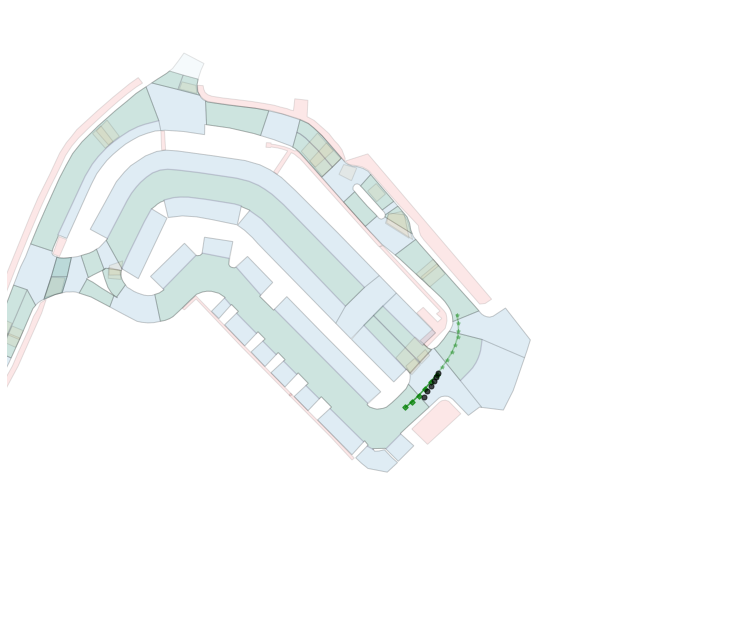

In [14]:
ph = 6
print(len(scene.nodes))
print(len(scene.present_nodes(np.array([5]), return_robot=False)[5]))
with torch.no_grad():
    timestep = np.array([7])
    predictions = eval_stg_nm.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_nm.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=False,
                                        full_dist=True,
                                         all_z_sep=False,
                                      gmm_mode=False)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    print("patch", my_patch)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
    
    #plot_vehicle_pseudo_set_by_id(ax,
    #                  predictions,
    #                  scene.dt,
    #                  "ego",
    #                  max_hl=10,
    #                  ph=ph,
    #                  map=None, x_min=x_min, y_min=y_min)
    
    #ax.plot(scene.nodes[1].data[:, ('position', 'x')] + x_min, scene.nodes[1].data[:, ('position', 'y')] + y_min, 'bo-', alpha=0.3)
    for node in scene.present_nodes(timestep)[timestep[0]]:
        if node.id != "ego":
            continue
        if node.type == "PEDESTRIAN":
            markersize = 3
        else:
            markersize = 4
        ts = timestep[0]
        end_idx = ts - node.first_timestep + ph + 1
        
        hist_line = ax.plot(node.data[:, ('position', 'x')][:ts+2] + x_min, node.data[:, ('position', 'y')][:ts+2] + y_min, '*-', alpha=0.3, markersize=markersize, c='g', zorder=605)
        c = hist_line[0].get_color()
        ax.plot(node.data[:, ('position', 'x')][ts+1:end_idx] + x_min, node.data[:, ('position', 'y')][ts+1:end_idx] + y_min, 'D-', alpha=0.7, markersize=markersize, c='g', zorder=605)
   

    #plot_vehicle_mm(ax,
    #                predictions_mm,
    #                scene.dt,
    #                max_hl=10,
    #                ph=ph,
    #                map=None, x_min=x_min, y_min=y_min)
    plot_vehicle_by_id(ax,
                    predictions_mm,
                    scene.dt,
                    "ego",
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)
    #ax.set_ylim((1385, 1435))
    #ax.set_xlim((850, 900))
    ax.set_ylim((y_min, y_max))
    ax.set_xlim((x_min, x_max))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_no_map_pos.pdf', dpi=300, bbox_inches='tight')

In [61]:
ph = 6
timestep = np.array([5])
features = eval_stg_nm.get_features(scene, timestep, ph, min_future_timesteps=ph, num_samples=1)
# print(features)

not integrating
not integrating


In [63]:
features["VEHICLE"][1]

gmm_mean_1                      \
                                                     0         1         2   
VEHICLE/ego                              0   -0.136381  0.060334 -0.078649   
                                         1   -0.098545  0.038803 -0.020965   
                                         2   -0.093315  0.085266 -0.065379   
                                         3   -0.129762  0.022202 -0.092444   
                                         4   -0.187066 -0.144491  0.085538   
                                         5    0.068267 -4.485043 -4.565399   
                                         6   -0.078019  0.104479 -0.067569   
                                         7   -0.083151   0.12983 -0.173803   
                                         8   -0.119097  0.189528  0.549074   
                                         9   -0.042108  0.016458 -0.027464   
                                         10  -0.206107  0.068999 -0.016386   
                                         11  -0.016898  0.080491 -0.136429   
                                         12  -0.653418  0.261191 -0.750839   
                                         13  -0.084401  0.060311 -0.054767   
                                         14  -0.226614  0.141401 -0.122772   
                                         15  -0.416204  -0.03072 -0.256266   
                                         16  -0.142393  0.053789 -0.051625   
                                         17  -0.277157  0.028223 -0.154447   
                                         18  -0.232501  0.098931 -0.078979   
                                         19  -0.173934  0.161787 -0.170891   
                                         20  -0.136241  0.148515 -0.160083   
                                         21   0.041631 -0.061279  0.015241   
                                         22  -0.167276  0.129937  -0.05518   
                                         23   3.459118  3.489226  2.522305   
                                         24  -0.252624  0.056724 -0.082376   
VEHICLE/8a26f7d33ff04b1a8c8679f8c4a7da91 0   -0.062587 -0.038952 -0.063906   
                                         1    -0.00514 -0.002359 -0.023065   
                                         2   -0.000399 -0.003123 -0.000691   
                                         3   -0.148815 -0.095394 -0.236846   
                                         4   -0.072771 -0.013677 -0.008009   
                                         5   -0.073221  -7.32542 -4.205586   
                                         6     -0.0035 -0.001652  0.001404   
                                         7   -0.000959 -0.013321  0.003749   
                                         8   -0.109765  0.032201  0.166259   
                                         9   -0.008467 -0.021362 -0.016267   
                                         10  -0.035385 -0.019095 -0.030848   
                                         11  -0.013916 -0.028027 -0.026798   
                                         12  -0.299307  0.074782 -0.652106   
                                         13   0.016981  0.001921 -0.007154   
                                         14  -0.046179 -0.010809 -0.026147   
                                         15    -0.2487 -0.146146 -0.266425   
                                         16   0.010059 -0.002951 -0.017147   
                                         17  -0.022625 -0.028321 -0.014094   
                                         18  -0.006284 -0.002137 -0.019294   
                                         19  -0.040433 -0.009553 -0.016047   
                                         20  -0.006856 -0.007065  0.002197   
                                         21    0.01453 -0.007909 -0.006945   
                                         22  -0.004093 -0.012533  0.004109   
                                         23   3.890936  4.809368  2.868406   
                                         24  -0.072163 -0.001052 -

## Prediction including Map Encoding

In [ ]:
model_dir = os.path.join(log_dir, 'int_ee_me') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=12)

In [ ]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_map_pos.pdf', dpi=300, bbox_inches='tight')

## Prediction using velocity output

In [ ]:
model_dir = os.path.join(log_dir, 'ee_vel') 
eval_stg_vel, hyp = load_model(model_dir, eval_env, ts=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


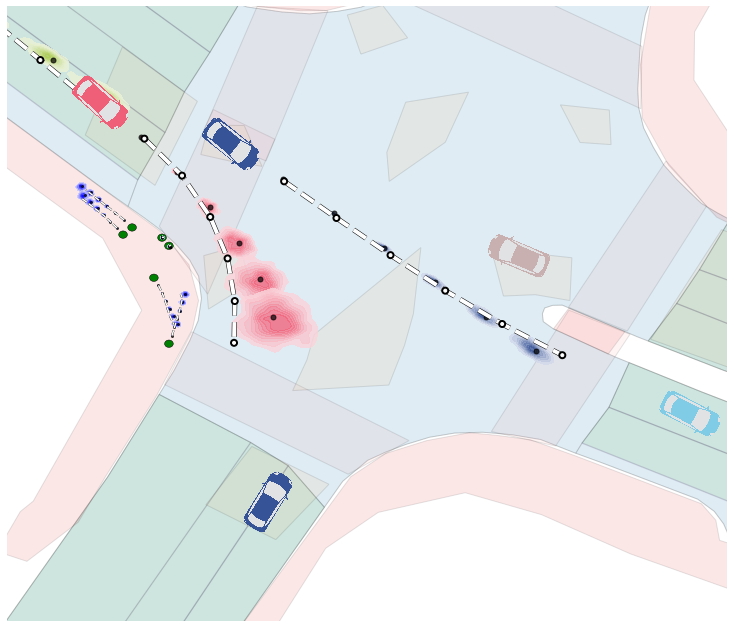

In [19]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_vel.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_vel.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_no_map_vel.pdf', dpi=300, bbox_inches='tight')

## Prediction using velocity output and map

In [15]:
model_dir = os.path.join(log_dir, 'me_vel') 
eval_stg_vel_map, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/me_vel/model_registrar-12.pt
Loaded!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


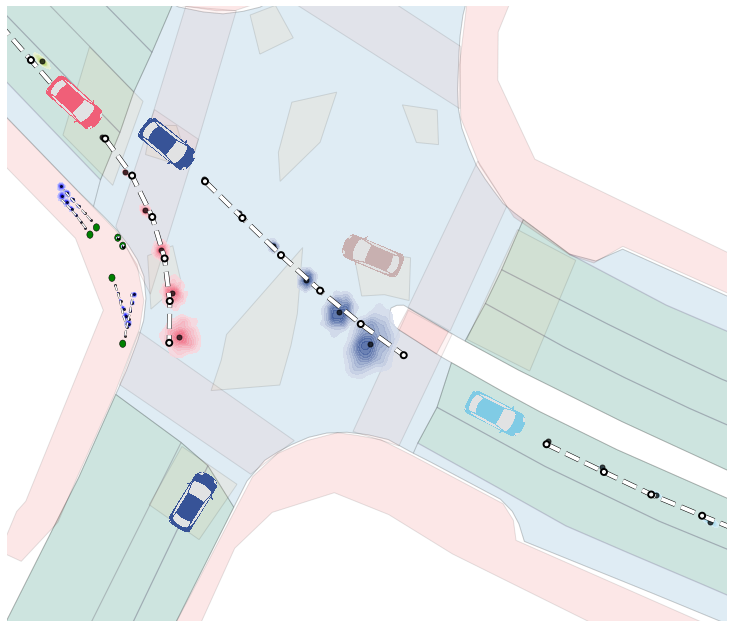

In [17]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_vel_map.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_vel_map.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_map_vel.pdf', dpi=300, bbox_inches='tight')

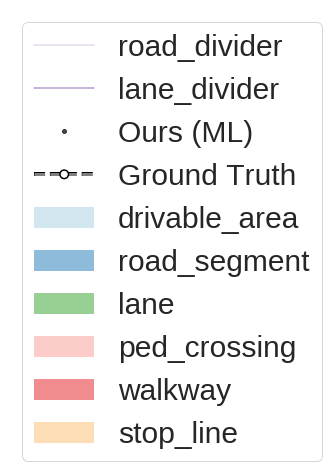

In [10]:
my_patch = (0, 0, 1, 1)
fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(1, 1), alpha=0.1, render_egoposes_range=False)
ax.plot([], [], 'ko',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (ML)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
leg = ax.legend(loc='upper left', fontsize=30, frameon=True)
for lh in leg.legendHandles:
    lh.set_alpha(.5)
ax.axis('off')
ax.grid('off')
fig.savefig('plots/qual_nuScenes_legend.pdf', dpi=300, bbox_inches='tight')